In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # For heatmaps
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import pointbiserialr  # For point-biserial correlation
from pure_ldp.frequency_oracles.direct_encoding import DEClient
from pure_ldp.frequency_oracles.local_hashing import LHClient
from pure_ldp.frequency_oracles.rappor import RAPPORClient, RAPPORServer
from pure_ldp.core import generate_hash
from pure_ldp.core.prob_simplex import project_probability_simplex
import random
import sys
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso
import os


In [ ]:

# Crear carpetas para resultados y figuras
os.makedirs('results', exist_ok=True)

# Crear subcarpetas organizadas para las figuras
figures_base = 'figures'
os.makedirs(figures_base, exist_ok=True)

# Subcarpetas para cada método de privacidad
privacy_methods = ['Direct_Encoding', 'OLH', 'RAPPOR']
for method in privacy_methods + ['Original']:
    method_path = os.path.join(figures_base, method)
    os.makedirs(method_path, exist_ok=True)
    # Subcarpetas para cada nivel de privacidad (Original y cada epsilon)
    subfolders = ['Original'] + [f'eps_{eps}' for eps in [5, 3, 1, 0.5, 0.1]]
    for subfolder in subfolders:
        os.makedirs(os.path.join(method_path, subfolder), exist_ok=True)

# Cargar datos
data_path = '../data/raw/bank-full.csv'
df = pd.read_csv(data_path, sep=';')
df['y'] = df['y'].map({'no': 0, 'yes': 1})
X = df.drop(columns=['y'])
y = df['y']

# Mejores parámetros encontrados
best_params_rf = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

# Número de iteraciones para promediar resultados
n_iterations = 10

# Función para mapear variables categóricas binarias y meses
def map_binary_columns(df):
    df['default'] = df['default'].map({'no': 0, 'yes': 1})
    df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
    df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
    df['month'] = df['month'].map({
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
        'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
        'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    })
    return df

# Función para convertir variables numéricas en categóricas
def convert_numerics_to_categories(df):
    bins_age = [18, 30, 40, 50, 60, 95]
    labels_age = ['18-30', '31-40', '41-50', '51-60', '61+']
    df['age'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, include_lowest=True)

    bins_balance = [-8019, 0, 72, 448, 1428, 102127]
    labels_balance = ['negative', '0-72', '73-448', '449-1428', '1429+']
    df['balance'] = pd.cut(df['balance'], bins=bins_balance, labels=labels_balance, include_lowest=True)

    bins_day = [1, 7, 14, 21, 31]
    labels_day = ['1-7', '8-14', '15-21', '22-31']
    df['day'] = pd.cut(df['day'], bins=bins_day, labels=labels_day, include_lowest=True)

    bins_duration = [0, 103, 180, 319, 4918]
    labels_duration = ['0-103', '104-180', '181-319', '320+']
    df['duration'] = pd.cut(df['duration'], bins=bins_duration, labels=labels_duration, include_lowest=True)

    bins_campaign = [1, 2, 3, 10, 63]
    labels_campaign = ['1', '2-3', '4-10', '11+']
    df['campaign'] = pd.cut(df['campaign'], bins=bins_campaign, labels=labels_campaign, include_lowest=True)

    bins_pdays = [-1, 0, 30, 90, 871]
    labels_pdays = ['no_contact', '0-30', '31-90', '91+']
    df['pdays'] = pd.cut(df['pdays'], bins=bins_pdays, labels=labels_pdays, include_lowest=True)

    bins_previous = [0, 1, 2, 5, 275]
    labels_previous = ['0', '1-2', '3-5', '6+']
    df['previous'] = pd.cut(df['previous'], bins=bins_previous, labels=labels_previous, include_lowest=True)

    return df

# Función para mapear variables categóricas a valores numéricos
def map_categorical_columns(df, categorical_columns):
    mappings = {}
    for col in categorical_columns:
        unique_values = df[col].unique()
        mappings[col] = {value: idx for idx, value in enumerate(unique_values) if pd.notna(value)}
        df[col] = df[col].map(mappings[col])
    return df, mappings

# Funciones para aplicar DE, OLH y RAPPOR
def apply_de(df, epsilon, categorical_columns):
    df_de = df.copy()
    for col in categorical_columns:
        de = DEClient(epsilon=epsilon, d=df[col].nunique())
        df_de[col] = df_de[col].apply(lambda x: de.privatise(int(x)))
    return df_de

def apply_olh(df, epsilon, categorical_columns):
    df_olh = df.copy()
    for col in categorical_columns:
        d = df[col].nunique()
        olh = LHClient(epsilon=epsilon, d=d, use_olh=True)
        df_olh[col] = df_olh[col].apply(lambda x: olh.privatise(int(x))[0] % d)
    return df_olh

class FixedRAPPORClient(RAPPORClient):
    def _perturb(self, data):
        perturbed_data = data.copy()
        for i, bit in enumerate(perturbed_data):
            u = random.random()
            if bit == 1:
                if u < 0.5 * self.f:
                    perturbed_data[i] = 0
            else:
                if u < 0.5 * self.f:
                    perturbed_data[i] = 1
        return perturbed_data

class FixedRAPPORServer(RAPPORServer):
    def _update_estimates(self):
        y = self._create_y()
        X = self._create_X()
        if self.reg_const == 0:
            model = LinearRegression(positive=True, fit_intercept=False)
        else:
            model = ElasticNet(positive=True, alpha=self.reg_const,
                               l1_ratio=0, fit_intercept=False,
                               max_iter=100000)
        if self.d > 1000 or self.lasso:
            lasso_model = Lasso(alpha=0.8, positive=True)
            lasso_model.fit(X, y)
            indexes = np.nonzero(lasso_model.coef_)[0]
            X_red = X[:, indexes]
            model.fit(X_red, y)
            self.estimated_data[indexes] = model.coef_ * self.num_of_cohorts
        else:
            model.fit(X, y)
            self.estimated_data = model.coef_ * self.num_of_cohorts

def apply_rappor(df, epsilon, categorical_columns):
    x = df.copy()
    for col in categorical_columns:
        d = x[col].nunique()
        m = 128
        k = 2
        num_of_cohorts = 8
        temp_client = FixedRAPPORClient(f=0.5, m=m, hash_funcs=[[]])
        f = temp_client.convert_eps_to_f(epsilon)
        hash_funcs = []
        for i in range(num_of_cohorts):
            cohort_hashes = [generate_hash(m, random.randint(0, sys.maxsize)) for _ in range(k)]
            hash_funcs.append(cohort_hashes)
        rappor_client = FixedRAPPORClient(f=f, m=m, hash_funcs=hash_funcs, num_of_cohorts=num_of_cohorts)
        rappor_server = FixedRAPPORServer(f=f, m=m, k=k, d=d, num_of_cohorts=num_of_cohorts)
        bit_vectors = []
        for i in range(len(x)):
            value = int(x[col].iloc[i])
            bv = rappor_client.privatise(value)
            bit_vectors.append(bv)
        for bv in bit_vectors:
            rappor_server.aggregate(bv)
        freqs = {}
        for i in range(d):
            freqs[i] = max(rappor_server.estimate(i), 0)
        freqs_array = np.array([freqs[i] for i in range(d)])
        normalized_freqs = project_probability_simplex(freqs_array)
        mapping = {i: normalized_freqs[i] for i in range(d)}
        x[col] = x[col].map(mapping)
    return x

# Función para generar heatmaps de correlación entre features y target
def plot_correlation_heatmap(X, y, title, filepath):
    df_combined = X.copy()
    df_combined['y'] = y
    correlations = {}
    for col in X.columns:
        if df_combined[col].isna().any():
            df_combined[col] = df_combined[col].fillna(0)
        corr, _ = pointbiserialr(df_combined['y'], df_combined[col])
        correlations[col] = corr
    corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation with y'])
    plt.figure(figsize=(8, 10))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, cbar_kws={'label': 'Correlation'})
    plt.title(title)
    plt.xlabel('Target (y)')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()

# Nueva función para generar matrices de conteo (heatmaps) de feature vs target
def plot_feature_target_count_matrices(X_original, X_privatized, y, categorical_columns, cat_mappings, method, model_name):
    # Usar los datos originales (antes de mapear a numéricos) para obtener las categorías originales
    df_original = X_original.copy()
    df_original['y'] = y
    # Usar los datos privatizados para generar las matrices
    df_privatized = X_privatized.copy()
    df_privatized['y'] = y

    for col in categorical_columns:
        # Obtener las categorías originales del feature
        categories = list(cat_mappings[col].keys())
        # Crear una matriz de conteo: filas son las categorías del target (0, 1), columnas son las categorías del feature
        count_matrix = pd.crosstab(df_privatized['y'], df_privatized[col])
        # Asegurarse de que todas las categorías estén presentes en las columnas
        count_matrix = count_matrix.reindex(columns=range(len(categories)), fill_value=0)
        # Renombrar las columnas con las categorías originales
        count_matrix.columns = categories
        # Asegurarse de que el índice (y) tenga las etiquetas correctas
        count_matrix.index = ['y=0', 'y=1']

        # Crear el heatmap
        plt.figure(figsize=(max(6, len(categories) * 0.5), 3))
        sns.heatmap(count_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.title(f'Count Matrix: {col} vs Target ({method}, {model_name})')
        plt.xlabel(f'{col} Categories')
        plt.ylabel('Target (y)')
        plt.tight_layout()
        # Guardar en la carpeta correspondiente
        filepath = os.path.join('figures', method, model_name, f'count_matrix_{col}.png')
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()

# Procesamiento completo (modificado para devolver el modelo entrenado y las características seleccionadas)
def process_data(X, y, categorical_columns, method='none', epsilon=None):
    x = X.copy()
    if method == 'de' and epsilon:
        x = apply_de(x, epsilon, categorical_columns)
    elif method == 'olh' and epsilon:
        x = apply_olh(x, epsilon, categorical_columns)
    elif method == 'rappor' and epsilon:
        x = apply_rappor(x, epsilon, categorical_columns)
    
    x = pd.get_dummies(x, columns=categorical_columns, drop_first=True, dtype='int64')
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    smoteenn = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)
    rf = RandomForestClassifier(**best_params_rf, random_state=42)
    boruta = BorutaPy(rf, n_estimators='auto', verbose=0)
    boruta.fit(X_train_resampled.values, y_train_resampled.values)
    selected_features = X_train_resampled.columns[boruta.support_].tolist()
    
    # Entrenar el modelo final con las características seleccionadas
    model = RandomForestClassifier(**best_params_rf, random_state=42)
    model.fit(X_train_resampled[selected_features], y_train_resampled)
    
    return X_train_resampled[selected_features], X_test[selected_features], y_train_resampled, y_test, model, selected_features

# Entrenar y evaluar modelo (modificado para devolver el modelo)
def evaluate_model(X_train, y_train, X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    conf_matrix = confusion_matrix(y_test, y_pred)
    actual_negatives, actual_positives = conf_matrix[0].sum(), conf_matrix[1].sum()
    false_positive_pct = conf_matrix[0][1] / actual_negatives if actual_negatives > 0 else 0
    false_negative_pct = conf_matrix[1][0] / actual_positives if actual_positives > 0 else 0
    return {
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Type I Error': false_positive_pct,
        'Type II Error': false_negative_pct
    }

# Función para calcular la importancia de las características y guardarlas
def save_feature_importance(model, selected_features, method, model_name):
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    filepath = os.path.join('results', f'feature_importance_{method}_{model_name}.csv')
    feature_importance_df.to_csv(filepath, index=False)
    return feature_importance_df

# Función para ejecutar múltiples iteraciones y calcular estadísticas (modificado para manejar importancia de características)
def run_iterations(X, y, X_original, categorical_columns, cat_mappings, method, epsilon, n_iterations):
    results = []
    feature_importances = []
    for _ in range(n_iterations):
        X_train, X_test, y_train, y_test, model, selected_features = process_data(
            X, y, categorical_columns, method=method, epsilon=epsilon
        )
        result = evaluate_model(X_train, y_train, X_test, y_test, model)
        results.append(result)
        # Calcular y almacenar la importancia de las características
        feature_importance_df = save_feature_importance(
            model, selected_features, method, 'Original' if method == 'none' else f'eps_{epsilon}'
        )
        feature_importances.append(feature_importance_df)
    return pd.DataFrame(results), feature_importances

# Función para calcular estadísticas (promedio, mínimo, máximo)
def compute_statistics(df):
    stats = {
        'mean': df.mean(),
        'min': df.min(),
        'max': df.max()
    }
    return stats


In [3]:


# Todas las columnas son ahora categóricas
all_categorical_columns = ['default', 'housing', 'loan', 'job', 'marital', 'education', 'contact', 'poutcome',
                           'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Epsilons y resultados
epsilons = [5, 3, 1, 0.5, 0.1]
results_de_stats = {}
results_olh_stats = {}
results_rappor_stats = {}
feature_importances_de = {}
feature_importances_olh = {}
feature_importances_rappor = {}

# Preprocesar datos originales
X_original = X.copy()  # Guardar una copia del original para los heatmaps de conteo
X = map_binary_columns(X)
X = convert_numerics_to_categories(X)
X, cat_mappings = map_categorical_columns(X, all_categorical_columns)


In [4]:

# Generar heatmap de correlación y matrices de conteo para los datos originales
print("Generando heatmap para datos originales...")
plot_correlation_heatmap(
    X, y, 'Correlation of Features with Target (Original Data)',
    os.path.join('figures', 'Original', 'Original', 'heatmap_correlation.png')
)
print("Generando matrices de conteo para datos originales...")
plot_feature_target_count_matrices(
    X_original, X, y, all_categorical_columns, cat_mappings, 'Original', 'Original'
)

Generando heatmap para datos originales...
Generando matrices de conteo para datos originales...


In [5]:
# Generar heatmaps y matrices de conteo para cada método y epsilon después de la privatización
for epsilon in epsilons:
    # Direct Encoding
    print(f"Generando heatmap para Direct Encoding (ε={epsilon})...")
    X_de = apply_de(X.copy(), epsilon, all_categorical_columns)
    plot_correlation_heatmap(
        X_de, y, f'Correlation of Features with Target (Direct Encoding, ε={epsilon})',
        os.path.join('figures', 'Direct_Encoding', f'eps_{epsilon}', 'heatmap_correlation.png')
    )
    print(f"Generando matrices de conteo para Direct Encoding (ε={epsilon})...")
    plot_feature_target_count_matrices(
        X_original, X_de, y, all_categorical_columns, cat_mappings, 'Direct_Encoding', f'eps_{epsilon}'
    )
    
    # OLH
    print(f"Generando heatmap para OLH (ε={epsilon})...")
    X_olh = apply_olh(X.copy(), epsilon, all_categorical_columns)
    plot_correlation_heatmap(
        X_olh, y, f'Correlation of Features with Target (OLH, ε={epsilon})',
        os.path.join('figures', 'OLH', f'eps_{epsilon}', 'heatmap_correlation.png')
    )
    print(f"Generando matrices de conteo para OLH (ε={epsilon})...")
    plot_feature_target_count_matrices(
        X_original, X_olh, y, all_categorical_columns, cat_mappings, 'OLH', f'eps_{epsilon}'
    )
    
    # RAPPOR
    print(f"Generando heatmap para RAPPOR (ε={epsilon})...")
    X_rappor = apply_rappor(X.copy(), epsilon, all_categorical_columns)
    plot_correlation_heatmap(
        X_rappor, y, f'Correlation of Features with Target (RAPPOR, ε={epsilon})',
        os.path.join('figures', 'RAPPOR', f'eps_{epsilon}', 'heatmap_correlation.png')
    )
    print(f"Generando matrices de conteo para RAPPOR (ε={epsilon})...")
    plot_feature_target_count_matrices(
        X_rappor, X_rappor, y, all_categorical_columns, cat_mappings, 'RAPPOR', f'eps_{epsilon}'
    )


Generando heatmap para Direct Encoding (ε=5)...
Generando matrices de conteo para Direct Encoding (ε=5)...
Generando heatmap para OLH (ε=5)...
Generando matrices de conteo para OLH (ε=5)...
Generando heatmap para RAPPOR (ε=5)...


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.119e+07, tolerance: 8.358e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.496e+07, tolerance: 1.

Generando matrices de conteo para RAPPOR (ε=5)...
Generando heatmap para Direct Encoding (ε=3)...
Generando matrices de conteo para Direct Encoding (ε=3)...
Generando heatmap para OLH (ε=3)...
Generando matrices de conteo para OLH (ε=3)...
Generando heatmap para RAPPOR (ε=3)...


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.477e+08, tolerance: 4.954e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e+08, tolerance: 2.

Generando matrices de conteo para RAPPOR (ε=3)...
Generando heatmap para Direct Encoding (ε=1)...
Generando matrices de conteo para Direct Encoding (ε=1)...
Generando heatmap para OLH (ε=1)...
Generando matrices de conteo para OLH (ε=1)...
Generando heatmap para RAPPOR (ε=1)...


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.046e+08, tolerance: 2.100e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e+08, tolerance: 3.

Generando matrices de conteo para RAPPOR (ε=1)...
Generando heatmap para Direct Encoding (ε=0.5)...
Generando matrices de conteo para Direct Encoding (ε=0.5)...
Generando heatmap para OLH (ε=0.5)...
Generando matrices de conteo para OLH (ε=0.5)...
Generando heatmap para RAPPOR (ε=0.5)...


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\pure_ldp\core\_freq_oracle_server.py:76: RuntimeWarning: High privacy has been detected (epsilon = 0.964648227267553), estimations may be highly inaccurate on small datasets
  warnings.warn("High privacy has been detected (epsilon = " + str(self.epsilon) +
c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\pure_ldp\core\_freq_oracle_server.py:76: RuntimeWarning: High privacy has been detected (epsilon = 0.964648227267553), estimations may be highly inaccurate on small datasets
  warnings.warn("High privacy has been detected (epsilon = " + str(self.epsilon) +
c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\pure_ldp\core\_freq_oracle_server.py:76: RuntimeWarning: High privacy has been detected (epsilon = 0.9646482272675

Generando matrices de conteo para RAPPOR (ε=0.5)...
Generando heatmap para Direct Encoding (ε=0.1)...
Generando matrices de conteo para Direct Encoding (ε=0.1)...
Generando heatmap para OLH (ε=0.1)...
Generando matrices de conteo para OLH (ε=0.1)...
Generando heatmap para RAPPOR (ε=0.1)...


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\pure_ldp\core\_freq_oracle_server.py:76: RuntimeWarning: High privacy has been detected (epsilon = 0.16002133845479682), estimations may be highly inaccurate on small datasets
  warnings.warn("High privacy has been detected (epsilon = " + str(self.epsilon) +
c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.046e+09, tolerance: 4.096e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(

Generando matrices de conteo para RAPPOR (ε=0.1)...


In [6]:
# Modelo sin privacidad (Original)
results_original, feature_importances_original = run_iterations(
    X, y, X_original, all_categorical_columns, cat_mappings, method='none', epsilon=None, n_iterations=n_iterations
)
results_de_stats['Original'] = compute_statistics(results_original)
results_olh_stats['Original'] = results_de_stats['Original']
results_rappor_stats['Original'] = results_de_stats['Original']
feature_importances_de['Original'] = feature_importances_original
feature_importances_olh['Original'] = feature_importances_original
feature_importances_rappor['Original'] = feature_importances_original


In [7]:
# Ejecutar iteraciones para cada método y epsilon
for epsilon in epsilons:
    # Direct Encoding
    results_de, feature_importances_de_eps = run_iterations(
        X, y, X_original, all_categorical_columns, cat_mappings, method='de', epsilon=epsilon, n_iterations=n_iterations
    )
    results_de_stats[f'ε={epsilon}'] = compute_statistics(results_de)
    feature_importances_de[f'ε={epsilon}'] = feature_importances_de_eps
    
    # OLH
    results_olh, feature_importances_olh_eps = run_iterations(
        X, y, X_original, all_categorical_columns, cat_mappings, method='olh', epsilon=epsilon, n_iterations=n_iterations
    )
    results_olh_stats[f'ε={epsilon}'] = compute_statistics(results_olh)
    feature_importances_olh[f'ε={epsilon}'] = feature_importances_olh_eps
    
    # RAPPOR
    results_rappor, feature_importances_rappor_eps = run_iterations(
        X, y, X_original, all_categorical_columns, cat_mappings, method='rappor', epsilon=epsilon, n_iterations=n_iterations
    )
    results_rappor_stats[f'ε={epsilon}'] = compute_statistics(results_rappor)
    feature_importances_rappor[f'ε={epsilon}'] = feature_importances_rappor_eps


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.459e+08, tolerance: 4.935e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.288e+08, tolerance: 2.

In [8]:
# Guardar resultados en CSVs
def save_results_to_csv(stats_dict, method_name):
    data = {}
    for model, stats in stats_dict.items():
        data[f'{model} (mean)'] = stats['mean']
        data[f'{model} (min)'] = stats['min']
        data[f'{model} (max)'] = stats['max']
    df = pd.DataFrame(data).round(4)
    df.to_csv(f'results/{method_name}_results.csv')
    return df

print("Guardando resultados en CSVs...")
results_de_df = save_results_to_csv(results_de_stats, 'Direct_Encoding')
results_olh_df = save_results_to_csv(results_olh_stats, 'OLH')
results_rappor_df = save_results_to_csv(results_rappor_stats, 'RAPPOR')

Guardando resultados en CSVs...


In [69]:
# Función para graficar con bigotes verticales (métricas en el eje X, modelos en la leyenda)
def plot_results_with_whiskers(stats_dict, title, colors):
    metrics = list(stats_dict['Original']['mean'].keys())
    models = list(stats_dict.keys())
    n_metrics = len(metrics)
    n_models = len(models)
    
    plt.figure(figsize=(11, 6))
    x_positions = np.arange(n_metrics) * 1.3  # Espaciado entre las métricas
    
    for model_idx, model in enumerate(models):
        means = []
        mins = []
        maxs = []
        for metric in metrics:
            means.append(stats_dict[model]['mean'][metric])
            mins.append(stats_dict[model]['min'][metric])
            maxs.append(stats_dict[model]['max'][metric])
        
        plt.scatter(x_positions + (model_idx - (n_models-1)/2) * 0.15, means, 
                    color=colors[model_idx], label=model, s=85) 
        for metric_idx in range(n_metrics):
            plt.vlines(x_positions[metric_idx] + (model_idx - (n_models-1)/2) * 0.15, 
                       mins[metric_idx], maxs[metric_idx], 
                       color=colors[model_idx], linestyle='-', linewidth=1)
    
    plt.xticks(x_positions, metrics, rotation=45, fontdict={'fontsize': 11})
    plt.yticks(fontsize=11)
    plt.title(title, fontdict={'fontsize': 16, 'weight': 'bold'})
    plt.xlabel('Metrics', fontdict={'fontsize': 13})
    plt.ylabel('Value', fontdict={'fontsize': 13})
    plt.legend(title='Models', bbox_to_anchor=(1, 1), loc='upper left', fontsize=11, title_fontsize=13)  
    plt.tight_layout()
    plt.show()

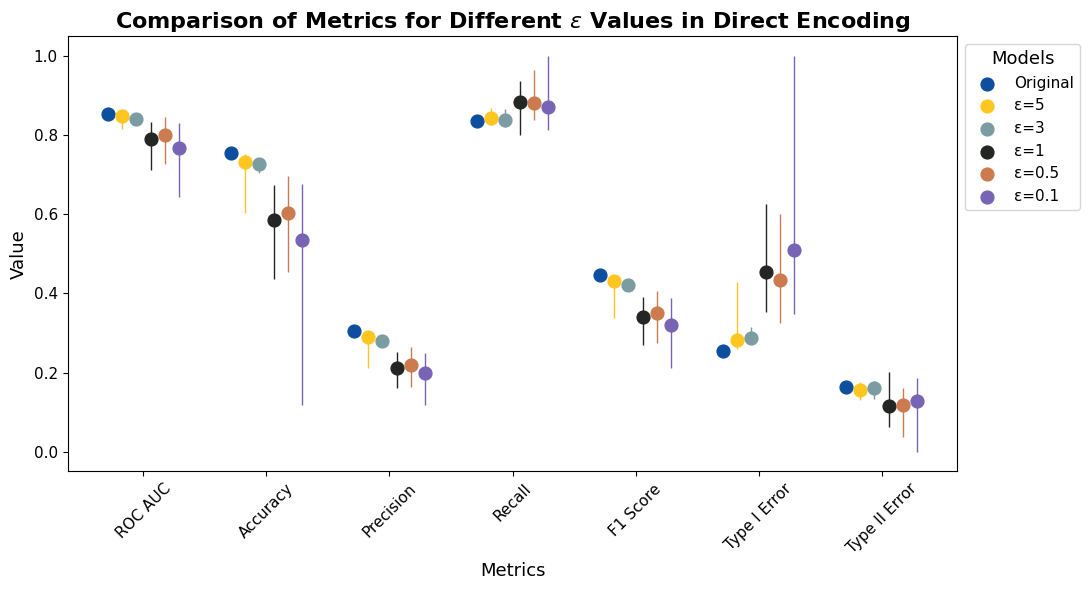

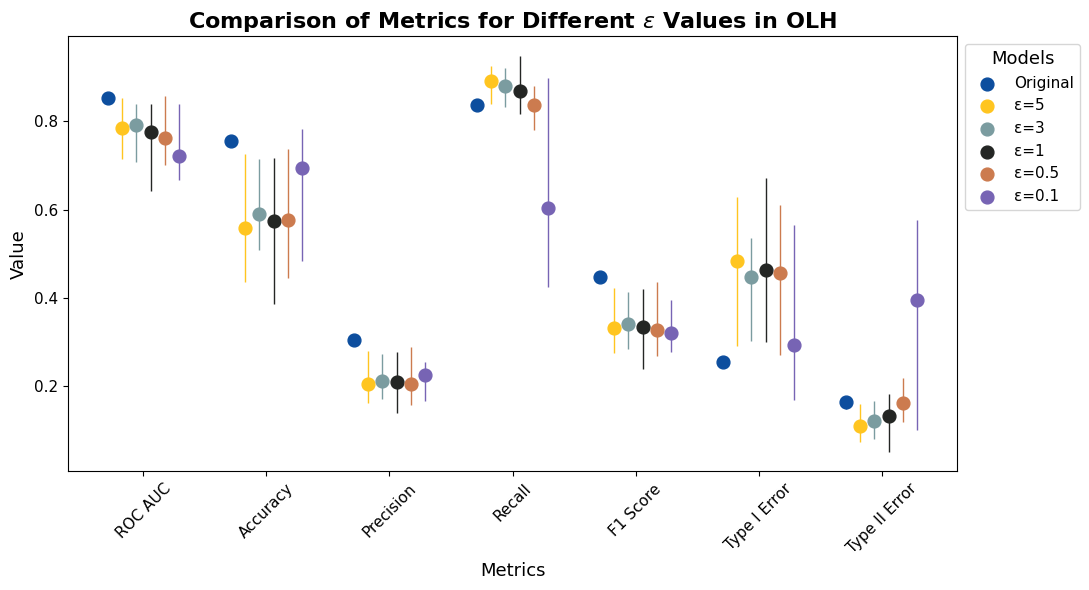

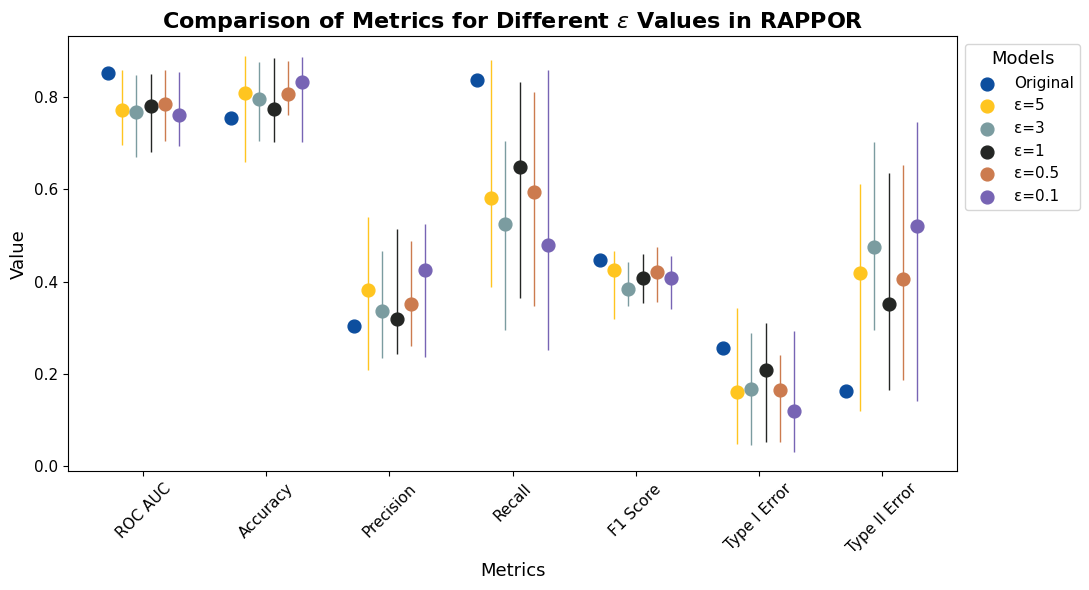

In [70]:
# Colores para los modelos (Original, ε=5, ε=3, ε=1, ε=0.5, ε=0.1)
colors = ['#0d4e9e', '#ffc520', '#7b9ca0', '#242624', '#cc7b4f', '#7764B4']

# Graficar resultados con bigotes verticales
plot_results_with_whiskers(results_de_stats, 'Comparison of Metrics for Different $\epsilon$ Values in Direct Encoding', colors)
plot_results_with_whiskers(results_olh_stats, 'Comparison of Metrics for Different $\epsilon$ Values in OLH', colors)
plot_results_with_whiskers(results_rappor_stats, 'Comparison of Metrics for Different $\epsilon$ Values in RAPPOR', colors)

In [12]:
# Función para graficar un radar chart
def plot_radar_chart(stats_dict, title, colors, filepath):
    # Métricas a incluir en el radar chart
    metrics = ['ROC AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
    models = list(stats_dict.keys())  # Niveles de privacidad (Original, ε=5, etc.)
    n_metrics = len(metrics)
    
    # Preparar los datos (usar las medias de cada métrica para cada modelo)
    data = []
    for model in models:
        values = [stats_dict[model]['mean'][metric] for metric in metrics]
        # Repetir el primer valor al final para cerrar el radar chart
        values += values[:1]
        data.append(values)
    
    # Calcular los ángulos para cada eje (métrica)
    angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Repetir el primer ángulo para cerrar el círculo
    
    # Crear el radar chart
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Graficar cada modelo (nivel de privacidad)
    for idx, (model_data, model) in enumerate(zip(data, models)):
        ax.fill(angles, model_data, color=colors[idx], alpha=0.25, label=model)
        ax.plot(angles, model_data, color=colors[idx], linewidth=2)
    
    # Configurar los ejes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=12)
    
    # Añadir etiquetas de valores en los ejes (máximo y mínimo)
    ax.set_rlabel_position(30)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
    plt.ylim(0, 1)
    
    # Añadir título y leyenda
    plt.title(title, size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=10)
    
    # Guardar la figura
    plt.tight_layout()
    plt.show()
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()

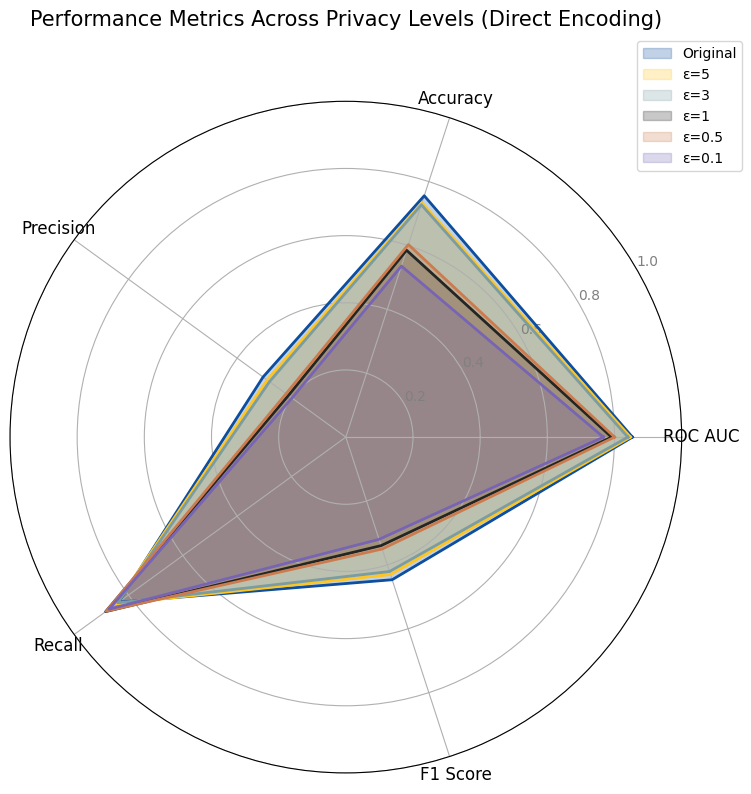

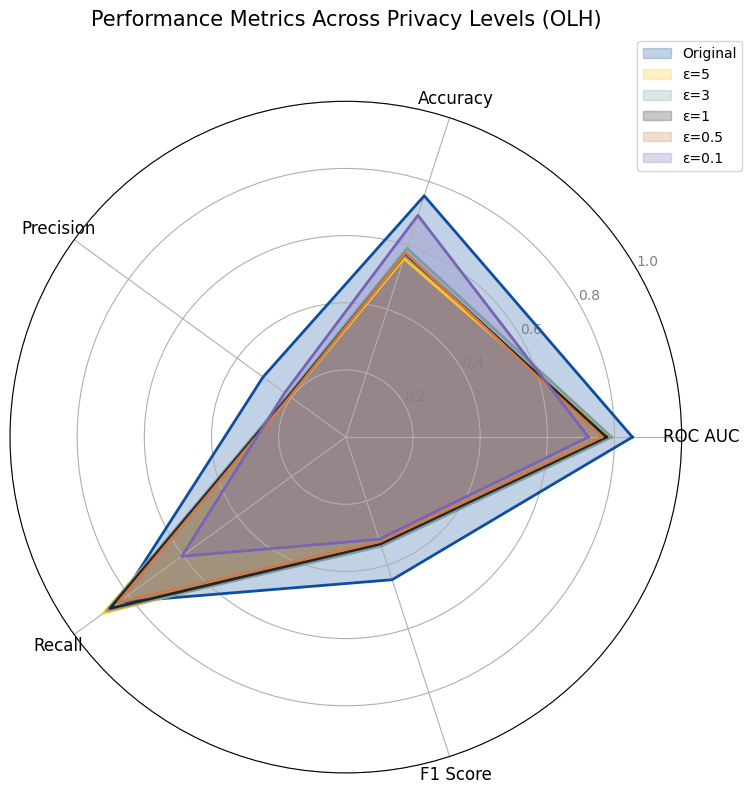

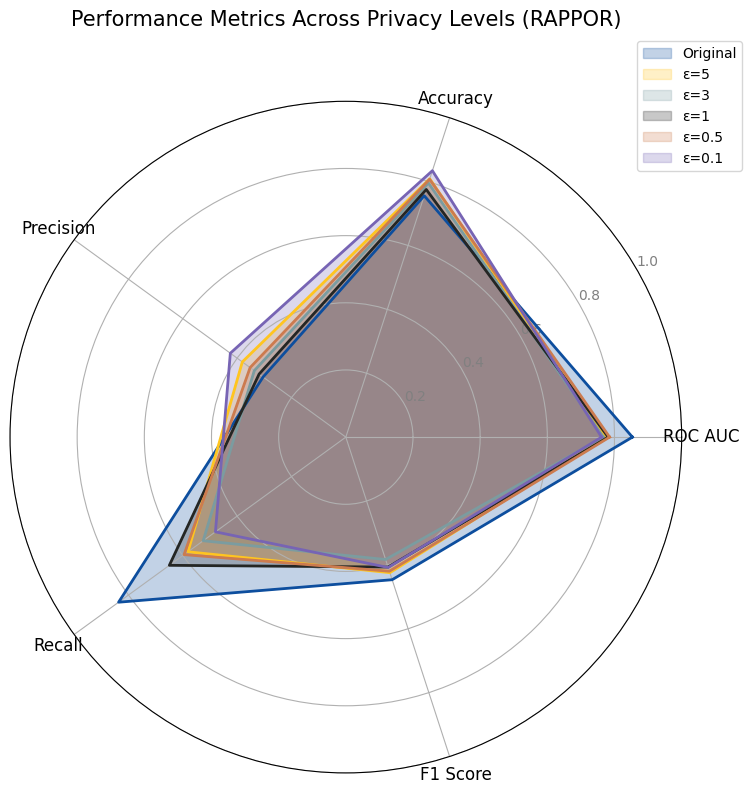

In [13]:
plot_radar_chart(
    results_de_stats,
    'Performance Metrics Across Privacy Levels (Direct Encoding)',
    colors,
    os.path.join('figures', 'Direct_Encoding', 'radar_chart.png')
)
plot_radar_chart(
    results_olh_stats,
    'Performance Metrics Across Privacy Levels (OLH)',
    colors,
    os.path.join('figures', 'OLH', 'radar_chart.png')
)
plot_radar_chart(
    results_rappor_stats,
    'Performance Metrics Across Privacy Levels (RAPPOR)',
    colors,
    os.path.join('figures', 'RAPPOR', 'radar_chart.png')
)